# Tutorial 2: ONERA OAT15A at high-speed stall conditions

### Outline
1. Introduction into the test case
2. Loading STL files and extracting a 2D airfoil from it (optional)
3. Preparing the input data for $S^3$
4. Executing $S^3$ and exporting the results


## 1. Introduction into the test case
This tutorial shows the application of $S^3$ for an *ONERA OAT15A* airfoil at high-speed flow conditions. We only analyze a *2D* slice of the scale-resolving simulation, which has already been saved to HDF5. The *ONERA OAT15A* airfoil is provided as an STL file.

The data for the *ONERA OAT15A* was kindly provided by research partners of the
[TU Stuttgart](https://www.for2895.uni-stuttgart.de/) within the research group unit *FOR2895*, the numerical setup can be found in:
  - **Kleinert, Johannes and Ehrle, Maximilian and Waldmann, Andreas and Lutz, Thorsten**.
  *Wake tail plane interactions for a tandem wing configuration in high-speed stall conditions*, 
  DOI: https://link.springer.com/article/10.1007/s13272-023-00670-1 (June, 2023).

Our first goal is to load the data from the flow simulation. In contrast to the first tutorial, we can't use the *load_foam_data* utility since we have stored our data in HDF5 binary format. Since we only have a 3D STL file representing the geometry but our simulation is only 2D, we then want to extract 2D coordinates of the airfoil. This step is only necessary to demontrate how to use 2D coordinates as geometry object within $S^3$. How to deal with STL files as geometry objects for *3D* simulations will be explained in a later tutorial.

Also we will learn how to use the `n_cells_max` as stopping criterion instead of approximation of the metric to limit the number of cells in the grid created by $S^3$.

**Note**: You need to have the *ONERA OAT15A* geometry and flow data. It can't be provided since it is proprietary. If you don' have access to these data, you may find [this repository](https://github.com/JanisGeise/airfoil_shape_optimization) helpful to generate some example data for this tutorial.
You can therefore just execute the [execute_validation.py](https://github.com/JanisGeise/airfoil_shape_optimization/blob/main/post_processing/execute_validation.py) using only a single angle of attack and the following CST parameters: 

$f_{max} = 0.0338, \quad t_{max} = 0.089, \quad x_f = 0.653, \quad KR = 0.8, \quad N_1 = 0.4, \quad N_2 = 1.1$

In this case, you also have to change the metric for $S^3$ to , e.g., $\sigma(|U|)$ since the simulation is incompressible.

## 2. Loading STL files and extracting a 2D airfoil from it (optional)
Now we are ready to start with the tutorial. We first load and visualize the data as we have already done it in the first tutorial.

In [1]:
import sys
import numpy as np
import torch as pt

from stl import mesh
from os.path import join
from os import environ, system

environ["sparseSpatialSampling"] = "../../.."
sys.path.insert(0, environ["sparseSpatialSampling"])

from sparseSpatialSampling.export import ExportData
from sparseSpatialSampling.sparse_spatial_sampling import SparseSpatialSampling
from sparseSpatialSampling.geometry import CubeGeometry, GeometryCoordinates2D

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


In [2]:
def load_airfoil_from_stl_file(_load_path: str, _name: str = "oat15.stl", sf: float = 1.0, dimensions: str = "xy",
                               x_offset: float = 0.0, y_offset: float = 0.0, z_offset: float = 0.0):
    """
    Example function for loading airfoil geometries stored as STL file and extract an enclosed 2D-area from it.
    Important Note:

        the structure of the coordinates within the stl files depends on the order the blocks are exported from
        Paraview; the goal is to form an enclosed area, through which we can draw a polygon. Therefore, the way of
        loading and sorting the data depends on the stl file. For an airfoil, the data can be sorted as:

            TE -> via suction side -> LE -> via pressure side -> TE

        It is helpful to export the airfoil geometry without a training edge and close it manually by connecting the
        last points from pressure to suction side

    :param _load_path: path to the STL file
    :param _name: name of the STL file
    :param sf: scaling factor, in case the airfoil needs to be scaled
    :param dimensions: which plane (orientation) to extract from the STL file
    :param x_offset: offset for x-direction, in case the airfoil should be shifted in x-direction
    :param y_offset: offset for y-direction, in case the airfoil should be shifted in y-direction
    :param z_offset: offset for z-direction, in case the airfoil should be shifted in z-direction
    :return: coordinates representing a 2D-airfoil as enclosed area
    """
    # mapping for the coordinate directions
    dim_mapping = {"x": 0, "y": 1, "z": 2}
    dimensions = [dim_mapping[d] for d in dimensions.lower()]

    # load stl file
    stl_file = mesh.Mesh.from_file(_load_path)

    # scale the airfoil to the original size used in CFD and shift if specified
    stl_file.x = stl_file.x * sf + x_offset
    stl_file.y = stl_file.y * sf + y_offset
    stl_file.z = stl_file.z * sf + z_offset

    # stack the coordinates (zeros column, because values are the same in all columns)
    coord_af = np.stack([stl_file.x[:, 0], stl_file.y[:, 0], stl_file.z[:, 0]], -1)

    # remove duplicates without altering the order -> required, otherwise the number of points is very large
    coord_af = coord_af[:, dimensions]
    _, idx = np.unique(coord_af, axis=0, return_index=True)
    coord_af = coord_af[np.sort(idx)]

    return coord_af

The original mesh of the simulation and the Mach number field at an arbitrary time step:

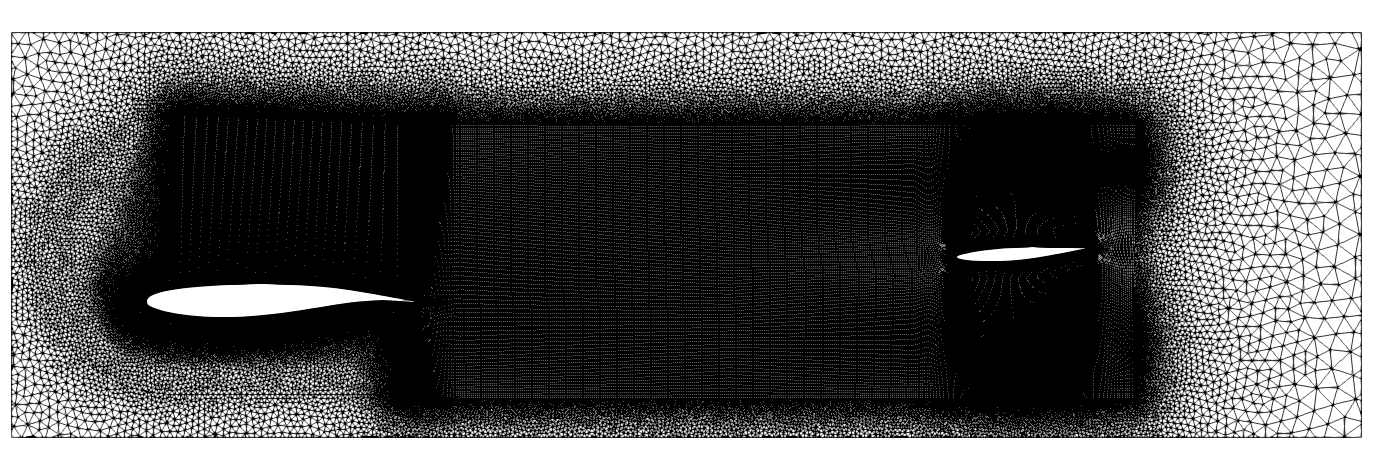
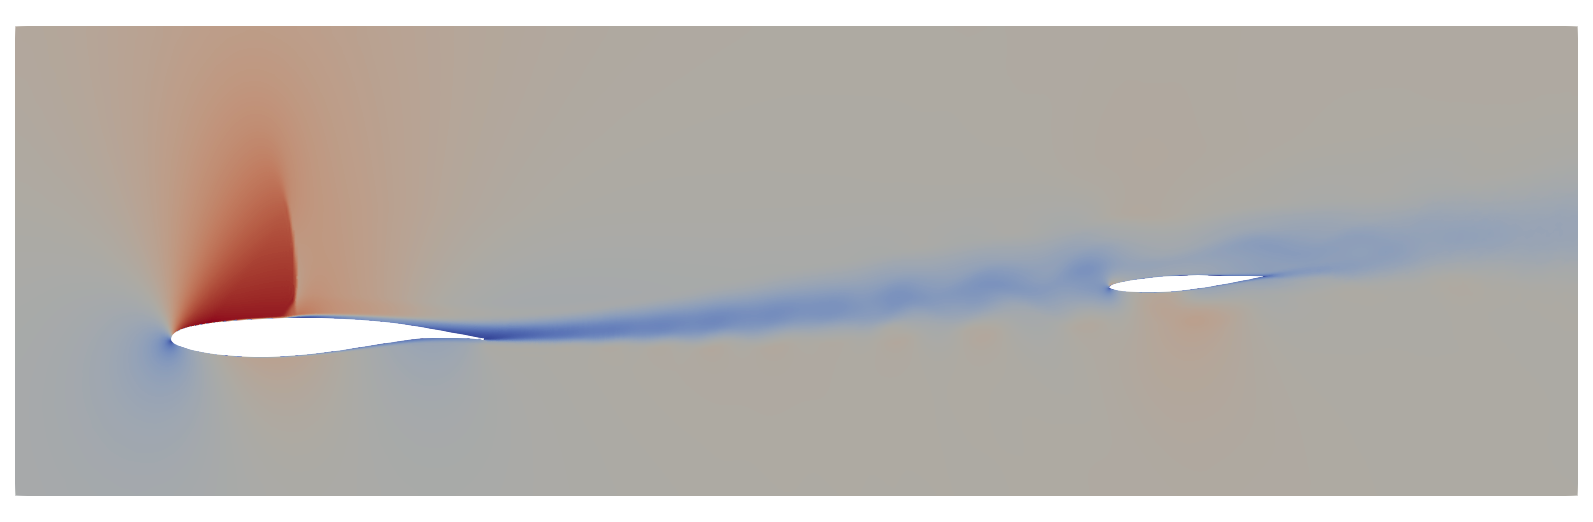

## 3. Preparing the input data for $S^3$

In [3]:
# path to the CFD data and settings, assuming they are in the top-level of the repository
load_path = join("..", "..", "..", "flowTorch_Workshop_2025")
save_path = join("..", "..", "..", "run", "tutorials", "tutorial_2")

# here we want to use the n_cells_max stopping criterion to generate max. 25 000 cells
n_cells_max = 25000
save_name = f"OAT15_{n_cells_max}_cells"

In [4]:
# load the coordinates of the original grid used in CFD
xz = pt.load(join(load_path, "OAT_example_data.pt"), weights_only=False)["xy"]

# load the Mach number field of the original CFD data
field = pt.load(join(load_path, "OAT_example_data.pt"), weights_only=False)["Ma"]

# compute the metric, we want to resolve the buffet, so it make sense to use the std(Ma)
metric = pt.std(field, dim=1)

The metric field then looks like this:

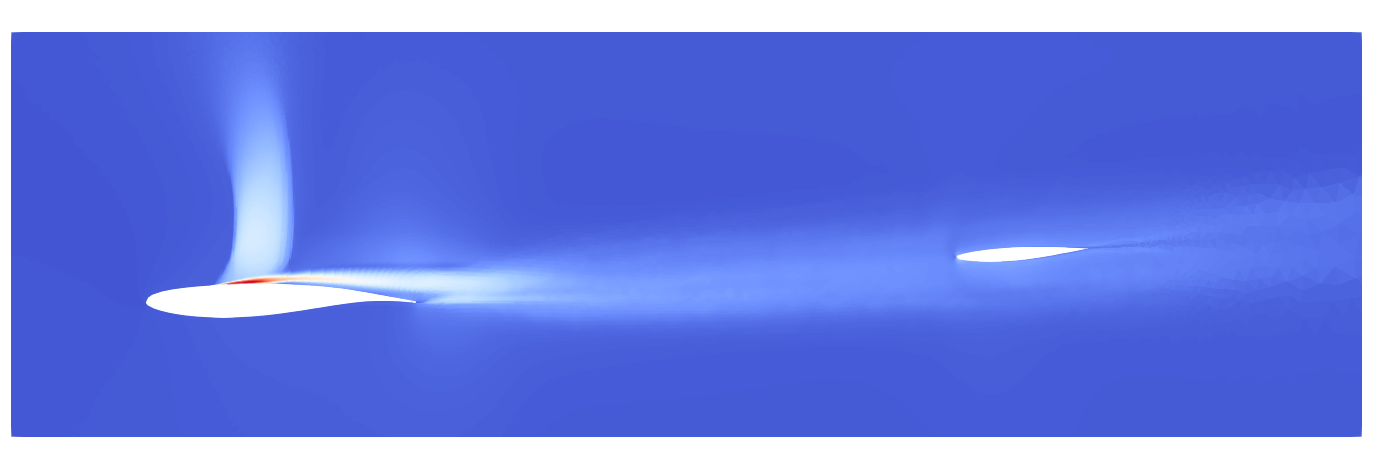

The metric is the highest at the shock near the airoil. Since $S^3$ generates cells based on the gradient of the metric, we expect cells being created in the vicinity of the airfoil, the shock and the wake of the airfoil.

In [5]:
# load the ONERA OAT15A geometry of the leading airfoil from an STL file
oat15 = load_airfoil_from_stl_file(join(load_path, "oat15_airfoil_no_TE.stl"), dimensions="xz")

# load the rear NACA airfoil from an STL file
naca = load_airfoil_from_stl_file(join(load_path, "naca_airfoil_no_TE.stl"), dimensions="xz")

# define the boundaries for the domain
bounds = [[pt.min(xz[:, 0]).item(), pt.min(xz[:, 1]).item()], [pt.max(xz[:, 0]).item(), pt.max(xz[:, 1]).item()]]

# assemble the geometry objects
geometry = [CubeGeometry("domain", True, bounds[0], bounds[1]),
            GeometryCoordinates2D("OAT15", False, oat15, refine=True),
            GeometryCoordinates2D("NACA", False, naca, refine=True)]

In [6]:
# load the corresponding write times for export
times = pt.load(join(load_path, "OAT_example_data.pt"), weights_only=False)["t"]

## 4. Executing $S^3$ and exporting the results

In [7]:
# instantiate an S^3 object
s_cube = SparseSpatialSampling(xz, metric, geometry, save_path, save_name, "OAT15", n_jobs=4, n_cells_max=n_cells_max,
                               write_times=times.tolist())

# execute S^3
s_cube.execute_grid_generation()

[2025-08-14 15:07:03] INFO     
	Selected settings:
		_pre_select          :	False
		_n_jobs              :	4
		_max_delta_level     :	False
		_geometry            :	['domain', 'OAT15', 'NACA']
		_min_metric          :	0.75
		_n_cells_max         :	25000
		_min_level           :	5
		_cells_per_iter_start:	245
		_cells_per_iter_end  :	245
		_cells_per_iter      :	245
		_cells_per_iter_last :	1000000000.0
		_reach_at_least      :	0.75
		_n_dimensions        :	2
		_n_cells_orig        :	245568
		_relTol              :	0.001
[2025-08-14 15:07:03] INFO     Starting refinement:
	Starting iteration no. 0, N_cells = 1
	Starting iteration no. 1, N_cells = 4
	Starting iteration no. 2, N_cells = 8
	Starting iteration no. 3, N_cells = 32
	Starting iteration no. 4, N_cells = 96
[2025-08-14 15:07:08] INFO     Finished uniform refinement.
[2025-08-14 15:07:08] INFO     Starting adaptive refinement.
	Starting iteration no. 0, N_cells = 320
	Starting iteration no. 1, N_cells = 1055
	Starting iteration 

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


[2025-08-14 15:07:31] INFO     Finished refinement in 27.8691 s 
								(35 iterations).
								Time for uniform refinement: 5.0110 s
								Time for adaptive refinement: 11.3101 s
								Time for geometry refinement: 6.6610 s
								Time for renumbering the final mesh: 4.8798 s
								
                                    Number of cells: 28919
                                    Minimum ref. level: 6
                                    Maximum ref. level: 12
                                    Captured metric of original grid: 56.29 %
                  


As shown in the last log file, we generated $28919$ cells. This is larger than our specified value of $25000$ cells, since we employed a subsequent geometry refinement, which is not acccounted for. However, looking the end of the first part of the log file, we can confirm that the stopping criterion was activated correctly:

...

Starting iteration no. 34, N_cells = 24990

...

In [8]:
# create export instance, export all fields into the same HFD5 file and create single XDMF from it
# Note: HDF5 may throws an error when running multiple notebooks in parallel. In that case close the other notebooks and restart the kernel
export = ExportData(s_cube)
export.export(xz, field.unsqueeze(1), "Ma")

[2025-08-14 15:07:31] INFO     Starting interpolation and export of field Ma.
[2025-08-14 15:07:36] INFO     Writing HDF5 file for field Ma.
[2025-08-14 15:07:36] INFO     Writing XDMF file for file OAT15_25000_cells.h5
[2025-08-14 15:07:36] INFO     Finished export of field Ma in 5.303s.


This completes the second tutorial. We can now visualize the final results in Paraview:

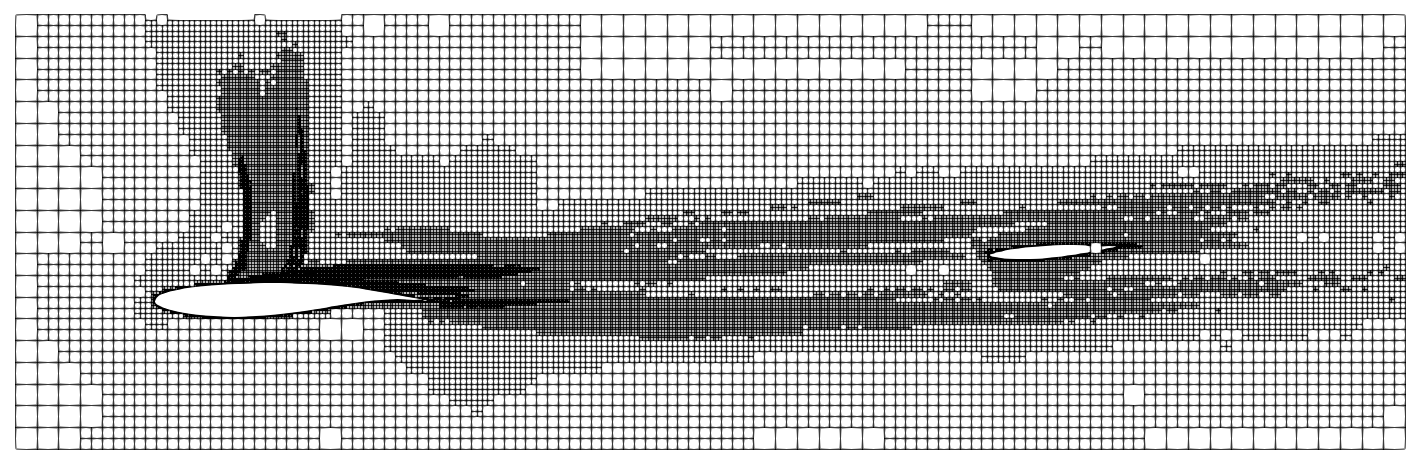
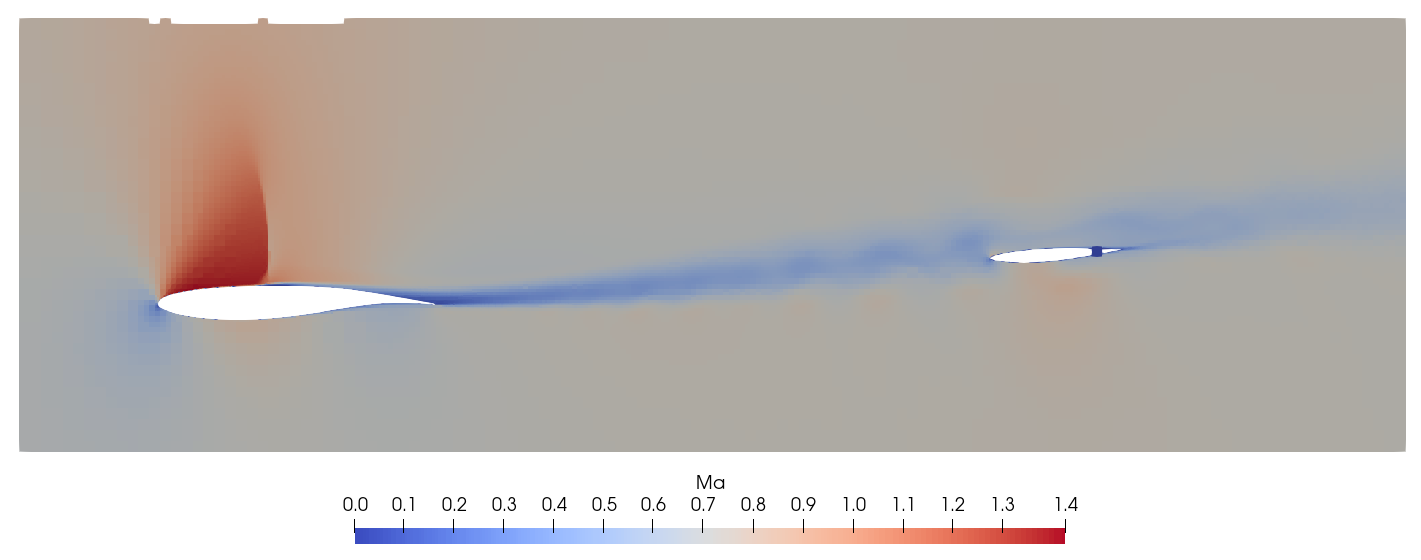

As you may noticed, there exists a single large cell near the trailing edge of the (rear) NACA airfoil even though we set the `refine` parameter within the geometry objects to `True`. This is because the metric almost doesn't change in this part of the flow field leading to relatively large cells. Since this cell's vertices are not in the direct vicinity of the airfoil surface, it doesn't get refined.

We will learn how to deal with these kind of problems in the next tutorial.